In [1]:
!pip install -e /home/sagar/modeling-info-spread

Obtaining file:///home/sagar/modeling-info-spread
  Preparing metadata (setup.py) ... done
  Attempting uninstall: src
    Found existing installation: src 0.3.4
    Uninstalling src-0.3.4:
      Successfully uninstalled src-0.3.4
  Running setup.py develop for src


In [206]:
import os
import matplotlib.pyplot as plt
from matplotlib import colormaps
from src.models.NSI import NSI
from src.models.channel import *
from tqdm.notebook import tqdm
import pickle
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from scipy import stats
from collections import defaultdict
import numpy as np
import networkx as nx
import matplotlib

In [212]:
#matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Arial') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update()
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'

# Channels

7 Channel Topologies

1. Binary Symmetric
2. Binary Asymmetric
3. Triangle
4. Cherry
5. Paw Channel
6. BA Model

Differences between 1 & 2 show differences between symmetric and asymmetric error probabilities, differences between 3 & 4 show differences between unique situation where one uniform and other is heterogeneous degree distributions but both have same steady state, 5 & 6 show effect of heterogeneous degree distribution. 

For the binary asymmetric channel, we make the asymmetry $|\epsilon_1 - \epsilon_\alpha| = 0.4$, but also a subset where we vary this. $\epsilon_1$ is fixed as $0.4$.

All channels are one-flip only. 

In [3]:
## Errors

lin_errors = np.linspace(0,1,21)
log_errors = np.logspace(-10,0,11)

log_errors = log_errors[log_errors != 0.1] # removing 0.1 because that's a duplicate

In [4]:
lin_errors, log_errors

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
        1.e-02, 1.e+00]))

In [5]:
## Binary Symmetric

bin_sym_channels = {
    
    'lin': {err: single_flip_channel(1, err) for err in lin_errors},
    'log': {err: single_flip_channel(1, err) for err in log_errors}
    
}

In [6]:
## Binary Asymmetric

bin_asym_channels = {
    
    'fixed': {
        
        'lin': {err: bin_asym_channel(err, (err - 0.4 )% 1) for err in lin_errors},
        'log': {err: bin_asym_channel(1, (err - 0.4) % 1) for err in log_errors}
        
    },
    
    'varying': {
        
        'lin': {err: bin_asym_channel(0.3, (0.3 - err) % 1) for err in lin_errors},
        'log': {err: bin_asym_channel(0.3, (0.3 - err) % 1) for err in log_errors}
        
    }
    
}

In [7]:
## Triangle

triangle_channels = {
    
    'lin': {err: simplex_channel(3, err) for err in lin_errors},
    'log': {err: simplex_channel(3, err) for err in log_errors}
    
}

In [8]:
## Cherry 

cherry_channels = {
    
    'lin': {err: star_channel(3, err) for err in lin_errors},
    'log': {err: star_channel(3, err) for err in log_errors}
    
}

In [9]:
## Paw Channel 

paw_channels = {
    
    'lin': {err: paw_channel(err) for err in lin_errors},
    'log': {err: paw_channel(err) for err in log_errors}
    
}

In [10]:
## BA Channel

G = nx.barabasi_albert_graph(n=100, m=2)

M = nx.adjacency_matrix(G).todense()

BA_channels = {
    
    'lin': {err: symmetric_graphical_channel(M, err) for err in lin_errors},
    'log': {err: symmetric_graphical_channel(M, err) for err in log_errors}
    
}

In [228]:
# confirming channel seeds
star_channel(3, 0.01)

array([[0.99 , 0.005, 0.005],
       [0.01 , 0.99 , 0.   ],
       [0.01 , 0.   , 0.99 ]])

# Constants

In [73]:
N = 10000
T = 1000

k = 4
beta = 0.01

num_sims = 20

# Simulations

In [74]:
dirpath = "/data_users1/sagar/modeling-info-spread/simulations"

In [75]:
os.mkdir(dirpath)

In [76]:
all_channels = [bin_sym_channels, bin_asym_channels, triangle_channels, 
                cherry_channels, paw_channels, BA_channels] 
all_names = ['bin_sym', 'bin_asym', 'triangle', 'cherry', 'paw', 'BA']

In [78]:
# Running all simulations with seed 0 

for name, channel_type in zip(all_names, all_channels): # trunc because cherry did
    
    print(f"Now simulating dynamics on {name} channels.")
    
    directory = dirpath + '/' + name
    
    try:
        os.mkdir(directory)
        
    except FileExistsError:
        pass
    
    directory = directory + '/seed0/'
    
    try:
        os.mkdir(directory)
        
    except FileExistsError:
        pass
    
    if name != 'bin_asym':
        
        for scale, channel_dict in channel_type.items():
            
            for err, channel in channel_dict.items():
                
                model = NSI(N=N, T=T, P=channel)
                
                for n in range(num_sims):
                    
                    subsubdir = directory + '/' + str(err)
                    
                    try:
                        os.mkdir(subsubdir)

                    except FileExistsError:
                        pass
                    
                    model.homogeneous_simulation(beta=beta, k=k, filepath=f"{subsubdir}/{n}", pbar_on=False)
                
    else:
        
        for key, error_type in channel_type.items():
            
            subdir = directory +"/" + key
            
            try:
                os.mkdir(subdir)

            except FileExistsError:
                pass
        
            for scale, channel_dict in error_type.items():

                for err, channel in channel_dict.items():
                    
                    model = NSI(N=N, T=T, P=channel)
                    
                    subsubdir = subdir + '/' + str(err) 

                    try:
                        os.mkdir(subsubdir)

                    except FileExistsError:
                        pass
                    
                    for n in range(num_sims):
                
                        model.homogeneous_simulation(beta=beta, k=k, filepath=f"{subsubdir}/{n}", pbar_on=False)

Now simulating dynamics on bin_sym channels.
Now simulating dynamics on bin_asym channels.
Now simulating dynamics on triangle channels.
Now simulating dynamics on cherry channels.
Now simulating dynamics on paw channels.
Now simulating dynamics on BA channels.


In [ ]:
# Seeding all other messages

for name, channel_type in zip(all_names,all_channels): # truncating because error occured on bin_asym
    
    print(f"Now simulating dynamics on {name} channels.")
    
    directory = dirpath + '/' + name
    
    if name != 'bin_asym':
        
        for scale, channel_dict in channel_type.items():
            
            for err, channel in channel_dict.items():
                
                alphabet_size = channel.shape[0]
                
                model = NSI(N=N, T=T, P=channel)
                
                for message in range(1, alphabet_size):
                    
                    subdir = directory + '/' + f"seed{message}"
                        
                    try:
                        os.mkdir(subdir)

                    except FileExistsError:
                        pass
                    
                    seed_dist = np.zeros(channel.shape[0])
                    seed_dist[message] = 1
                
                    for n in range(num_sims):

                        subsubdir = subdir + '/' + str(err)

                        try:
                            os.mkdir(subsubdir)

                        except FileExistsError:
                            pass

                        model.homogeneous_simulation(beta=beta, k=k, filepath=f"{subsubdir}/{n}", pbar_on=False,
                                                    seedI=seed_dist)
                
    else:
        
        for key, error_type in channel_type.items():
        
            for scale, channel_dict in error_type.items():

                for err, channel in channel_dict.items():
                    
                    model = NSI(N=N, T=T, P=channel)
                    alphabet_size = channel.shape[0]
                    
                    for message in range(alphabet_size): # running asym on all messages due to error last time
                    
                        subdir = directory + '/' + f"seed{message}" 

                        try:
                            os.mkdir(subdir)

                        except FileExistsError:
                            pass
                        
                        subsubdir = subdir + '/' + key

                        try:
                            os.mkdir(subsubdir)

                        except FileExistsError:
                            pass
                        
                        seed_dist = np.zeros(channel.shape[0])
                        seed_dist[message] = 1
                        
                        subsubsubdir = subsubdir + '/' + str(err)

                        try:
                            os.mkdir(subsubsubdir)

                        except FileExistsError:
                            pass

                        for n in range(num_sims):

                            model.homogeneous_simulation(beta=beta, k=k, filepath=f"{subsubsubdir}/{n}", pbar_on=False,
                                                    seedI=seed_dist)

Now simulating dynamics on bin_sym channels.
Now simulating dynamics on bin_asym channels.
Now simulating dynamics on triangle channels.
Now simulating dynamics on cherry channels.
Now simulating dynamics on paw channels.
Now simulating dynamics on BA channels.


In [81]:
test_loads = []
for f in os.listdir('/data_users1/sagar/modeling-info-spread/simulations/bin_sym/seed0/0.0'):
    a = np.load('/data_users1/sagar/modeling-info-spread/simulations/bin_sym/seed0/0.0/'+f)
    test_loads.append(a)

In [82]:
test_loads[0]['arr_0']

array([[1.e-04, 0.e+00],
       [1.e-04, 0.e+00],
       [1.e-04, 0.e+00],
       ...,
       [1.e+00, 0.e+00],
       [1.e+00, 0.e+00],
       [1.e+00, 0.e+00]])

In [85]:
# Missing some BA -- lets find out which

poi = '/data_users1/sagar/modeling-info-spread/simulations/BA' # Path of Interest
for seed in os.listdir(poi):
    
    num_errors = len(os.listdir(poi+'/'+seed))
    
    print(num_errors)
    

6
6
6
6
6
6
6
6
6
6
6
6
7
6
6
6
7
7
7
6
6
6
6
6
6
7
7
6
6
7
6
6
30
6
6
7
6
6
6
6
6
6
6
6
6
7
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
6
6
6
6
6
6
6
6
6
7
7
6
6
6
6
6
6
6
7
7
6
6
6
6
6
6
6


# $\phi$ plots

### SKIP BINARY SYMMETRIC FOR NOW, THERE IS AN ERROR

In [37]:
def phi_t(channel: str, 
          seed: int, 
          error: float, 
          average: bool = True, 
          error_type: str = None) -> np.ndarray:
    
    """
    Outputs the phi curve on T points corresponding to the simulation parameters specified. 
    If average is set to False, outputs 20 curves for each of the 20 simluated runs. 
    
    :param channel: channel name
    :param seed: initial seed message
    :param error: probability of error in communication
    :param average: return single curve averaging over all simulations at each time step (default=True)
    :param error_type: for binary asymmetric channels, specifies whether other errors are fixed or varying. Must 
    be either "fixed" or "varying"
    
    :returns: If avg=True, returns a 1xT numpy array corresponding to average value at each time step for all 20 
    runs. If avg=False, returns 20xT numpy array with each row being one simulation.
    """
    
    base_path = "/data_users1/sagar/modeling-info-spread/"
    
    seed = f"seed{seed}"
    error = str(error)
    
    loaded_arrays = list()
    
    if channel == "bin_asym":
        
        if error_type == "fixed":
            pass
        elif error_type == "varying":
            pass
        else:
            raise ValueError("channel_type must be 'fixed' or 'varying' for binary asymmetric channels")
        
        sim_path = base_path + f"{channel}/{seed}/{error_type}/{error}/"
        
        for sim in os.listdir(sim_path):
            arr = np.load(sim_path + sim)
            loaded_arrays.append(arr['arr_0'])
    else:
        
        sim_path = base_path + f"{channel}/{seed}/{error}/"
        
        for sim in os.listdir(sim_path):
            arr = np.load(sim_path + sim)
            loaded_arrays.append(arr['arr_0'])
    
    all_sims_arr = np.array(loaded_arrays)
    
    if average:
        return np.mean(all_sims_arr, axis=0)
    else:
        return all_sims_arr
    

In [49]:
phi_t('bin_sym', 0, 0.5, average=False)[0,:,:].shape

(1001, 2)

# $\pi$ plots

In [68]:
def pi_t(channel: str, 
         seed: int, 
         error: float, 
         average: bool = True, 
         error_type: str = None) -> np.ndarray:
    
    """
    Outputs the pi curve on T points corresponding to the simulation parameters specified. 
    If average is set to False, outputs 20 curves for each of the 20 simluated runs. 
    
    :param channel: channel name
    :param seed: initial seed message
    :param error: probability of error in communication
    :param average: return single curve averaging over all simulations at each time step (default=True)
    :param error_type: for binary asymmetric channels, specifies whether other errors are fixed or varying. Must 
    be either "fixed" or "varying"
    
    :returns: If avg=True, returns a TxA numpy array corresponding to average value at each time step for all 20 
    runs and all A messages. If avg=False, returns 20xTxA numpy array with each row being one simulation.
    """
    
    phi = phi_t(channel=channel, seed=seed, error=error, average=False, error_type=error_type)
    
    pi_arrs = list()
    
    for run in range(phi.shape[0]):
        sim = phi[run,:,:]
        totals = np.sum(sim, axis=1)
        pi = np.array([sim[:,0]/totals, sim[:,1]/totals])
        pi_arrs.append(pi.T)
        
        
    simulated_pi_arr = np.array(pi_arrs)
    
    if average:
        return np.mean(simulated_pi_arr, axis=0)
    else:
        return simulated_pi_arr

# $I$ plots

In [ ]:
def I_t(channel: str, 
        error: float, 
        average: bool = True, 
        error_type: str = None) -> np.ndarray:
    
    """
    """
    
    base_path = "/data_users1/sagar/modeling-info-spread/"
    
    channel_path = base_path + channel
    
    pi_by_seed = list()
    
    for seed, seed_str in enumerate(os.listdir(channel_path)):
        
        pi = pi_t(channel=channel, seed=seed, error=error, error_type=error_type)
        
        
        

# Simulating All I Curves

In [ ]:
# Running all simulations with 10 seeds and all possible seed distributions

num_sims = 1
seed_dists = [(1-i/10, i/10) for i in range(10)]
seed_labels = [f'{i[0]:.1f}' for i in seed_dists]

DIRPATH = "/data_users1/sagar/modeling-info-spread/simulations/information_simulations/'
try:
    os.mkdir(DIRPATH)
except: FileExistsError:
        pass

for name, channel_type in zip(all_names, all_channels): 
    
    print(f"Now simulating dynamics on {name} channels.")
    
    directory = DIRPATH + name
    
    try:
        os.mkdir(directory)
        
    except FileExistsError:
        pass
    
    for seed_name, seed_tup in zip(seed_labels, seed_dists):
        
        seed_dir = directory + '/' + seed_name
        
            try:
                os.mkdir(seed_dir)

            except FileExistsError:
                pass
    
        if name != 'bin_asym':

            for scale, channel_dict in channel_type.items():

                for err, channel in channel_dict.items():

                    model = NSI(N=N, T=T, P=channel)
                    
                    err_dir = seed_dir + '/' + str(err)

                        try:
                            os.mkdir(err_dir)

                        except FileExistsError:
                            pass

                    for n in range(num_sims):

                        model.homogeneous_simulation(beta=beta, k=k, filepath=f"{subsubdir}/{n}", pbar_on=False)

        else:

            for key, error_type in channel_type.items():

                subdir = directory +"/" + key

                try:
                    os.mkdir(subdir)

                except FileExistsError:
                    pass

                for scale, channel_dict in error_type.items():

                    for err, channel in channel_dict.items():

                        model = NSI(N=N, T=T, P=channel)

                        subsubdir = subdir + '/' + str(err) 

                        try:
                            os.mkdir(subsubdir)

                        except FileExistsError:
                            pass

                        for n in range(num_sims):

                            model.homogeneous_simulation(beta=beta, k=k, filepath=f"{subsubdir}/{n}", pbar_on=False)

# Noiseless Encoding, Noisy Spread

In [223]:
plt.style.use('/home/sagar/modeling-info-spread/docs/stylesheet.mplstyle')

In [94]:
all_errors = np.concatenate([lin_errors, log_errors])

In [132]:
all_names

['bin_sym', 'bin_asym', 'triangle', 'cherry', 'paw', 'BA']

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

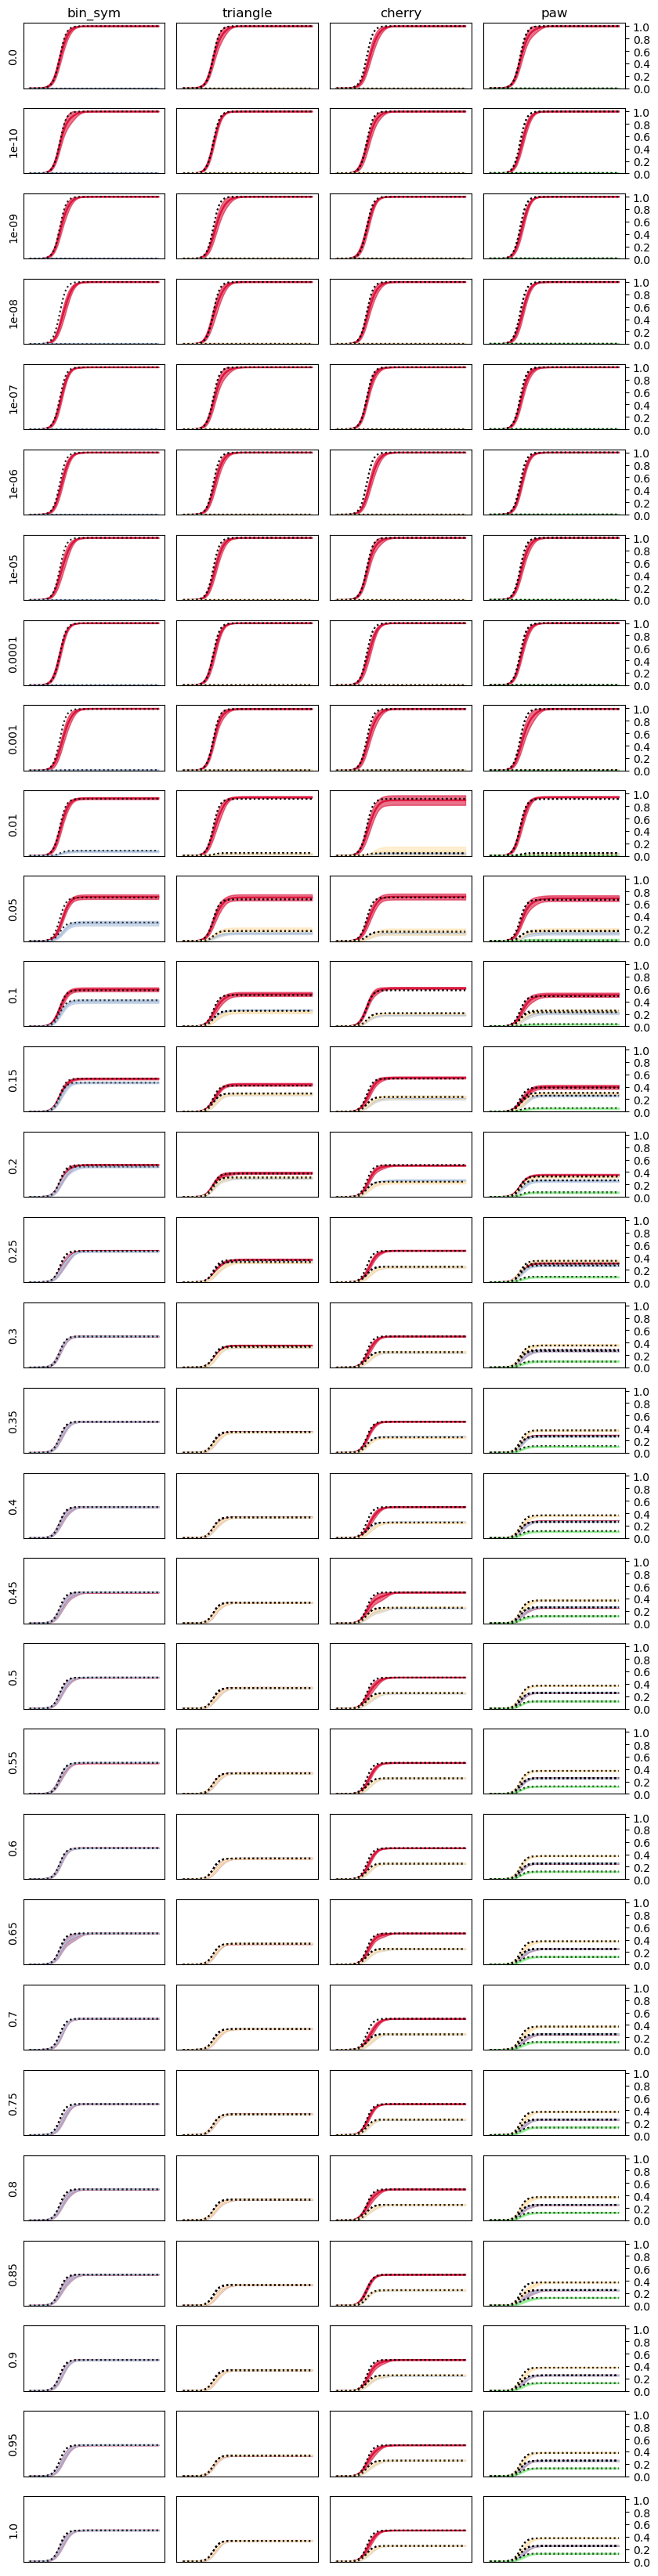

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

In [227]:
zero_seed_dirpath = "/data_users1/sagar/modeling-info-spread/simulations/"

fig, axs = plt.subplots(len(all_errors)-1, len(all_channels)-2, figsize=(8.5,33))

colors = ['crimson', 'lightsteelblue', 'moccasin', 'lightgreen']

channel_mapping = {
    
    'bin_sym': {err: single_flip_channel(1, err) for err in all_errors},
    'triangle': {err: simplex_channel(3, err) for err in all_errors},
    'cherry': {err: star_channel(3, err) for err in all_errors},
    'paw': {err: paw_channel(err) for err in all_errors},
    'bin_asym': None,
    'BA': None
    
}

channel_idx = 0
for name,channel in zip(all_names, all_channels):
    
    if (name !='bin_asym') and (name != 'BA'):
        
        channel_dir = zero_seed_dirpath + name
        
        seed = '/seed0/'
        
        seed_dir = channel_dir + seed
        
        error_idx = 0
        
        channel_size = 2
        
        error_folders = os.listdir(seed_dir)
        
        error_list = [(n, float(n)) for n in error_folders]
        error_list.sort(key=lambda x: x[1])
        
        sorted_error_folders = [e[0] for e in error_list]
        
        for err in sorted_error_folders:
            
            folder = seed_dir + err
            
            runs = list()
            
            for run in os.listdir(folder):
                
                f = folder + '/' + run
                
                y = np.load(f)
            
                runs.append(y['arr_0'])
                
                channel_size = y['arr_0'].shape[1]
                
            model_channel = channel_mapping[name][float(err)]
            model = NSI(N=N, T=T, P=model_channel)
            analytic = model.homogeneous_analytic(beta=beta, k=k, seedI=np.array([1/N]+[0]*(channel_size-1)))
            
            sim_arr = np.array(runs)
        
            sim_means = np.mean(sim_arr, axis=0)
            sim_se = np.std(sim_arr, axis=0) / np.sqrt(20)
            conf_int = 1.96 * sim_se
            
            sim_lower = sim_means - conf_int
            sim_higher = sim_means + conf_int
            
            sim_lower = np.clip(sim_lower, 0, 1)
            sim_higher = np.clip(sim_higher, 0, 1)
            
            for dim in range(sim_means.shape[1]):
                axs[error_idx, channel_idx].plot(range(1000), sim_means[:-1, dim], color=colors[dim])
                axs[error_idx, channel_idx].fill_between(range(1000), sim_means[:-1, dim], sim_lower[:-1, dim], 
                                                         alpha=0.6, color=colors[dim])
                axs[error_idx, channel_idx].fill_between(range(1000), sim_means[:-1, dim], sim_higher[:-1, dim], 
                                                         alpha=0.6, color=colors[dim])
                axs[error_idx, channel_idx].plot(range(1000), analytic.I, alpha=0.6, linestyle='dotted', 
                                                color='black')
            
            
            axs[error_idx, channel_idx].set_ylim(0, 1.05)
            
            if error_idx==0:
                axs[error_idx, channel_idx].set_title(name)
                
            if channel_idx==0:
                axs[error_idx, channel_idx].set_ylabel(f"{float(err):.3}")   
                
            if channel_idx==3:
                axs[error_idx, channel_idx].yaxis.tick_right()
                axs[error_idx, channel_idx].yaxis.set_label_position("right")
                axs[error_idx, channel_idx].set_yticks(np.linspace(0,1,6))
            else:
                axs[error_idx, channel_idx].set_yticks([])
                
            axs[error_idx, channel_idx].set_xticks([])  
              
            
            
            error_idx += 1
            
        channel_idx += 1
        
plt.tight_layout()
        
plt.show()

fig.savefig('/home/sagar/modeling-info-spread/reports/figures/full_discrete_plot.pdf')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

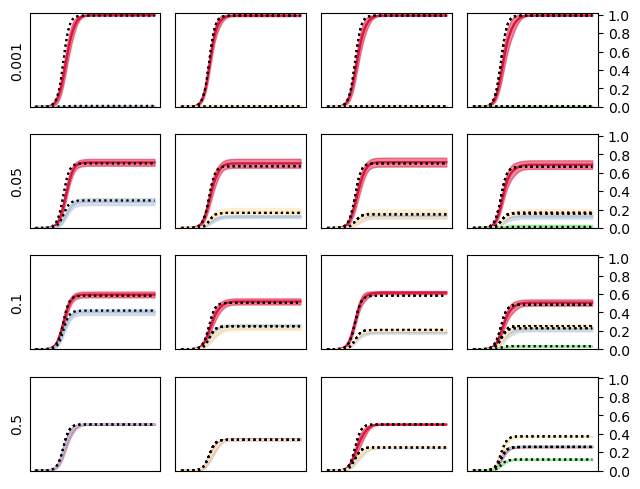

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

In [225]:
abridged_errors = [0.001, 0.05, 0.1, 0.5]

#matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
#matplotlib.rcParams['mathtext.rm'] = 'Arial'

colors = ['crimson', 'lightsteelblue', 'moccasin', 'lightgreen']

zero_seed_dirpath = "/data_users1/sagar/modeling-info-spread/simulations/"

fig, axs = plt.subplots(len(abridged_errors), len(all_channels)-2, figsize=(6.5,5))

channel_mapping = {
    
    'bin_sym': {err: single_flip_channel(1, err) for err in all_errors},
    'triangle': {err: simplex_channel(3, err) for err in all_errors},
    'cherry': {err: star_channel(3, err) for err in all_errors},
    'paw': {err: paw_channel(err) for err in all_errors},
    'bin_asym': None,
    'BA': None
    
}

channel_idx = 0
for name,channel in zip(all_names, all_channels):
    
    if (name !='bin_asym') and (name != 'BA'):
        
        channel_dir = zero_seed_dirpath + name
        
        seed = '/seed0/'
        
        seed_dir = channel_dir + seed
        
        error_idx = 0
        
        channel_size = 2
        
        error_folders = os.listdir(seed_dir)
        
        error_list = [(n, float(n)) for n in error_folders if float(n) in abridged_errors]
        error_list.sort(key=lambda x: x[1])
        
        sorted_error_folders = [e[0] for e in error_list]
        
        for err in sorted_error_folders:
            
            folder = seed_dir + err
            
            runs = list()
            
            for run in os.listdir(folder):
                
                f = folder + '/' + run
                
                y = np.load(f)
            
                runs.append(y['arr_0'])
                
                channel_size = y['arr_0'].shape[1]
                
            model_channel = channel_mapping[name][float(err)]
            model = NSI(N=N, T=T, P=model_channel)
            analytic = model.homogeneous_analytic(beta=beta, k=k, seedI=np.array([1/N]+[0]*(channel_size-1)))
            
            sim_arr = np.array(runs)
        
            sim_means = np.mean(sim_arr, axis=0)
            sim_se = np.std(sim_arr, axis=0) / np.sqrt(20)
            conf_int = 1.96 * sim_se
            
            sim_lower = sim_means - conf_int
            sim_higher = sim_means + conf_int
            
            sim_lower = np.clip(sim_lower, 0, 1)
            sim_higher = np.clip(sim_higher, 0, 1)
            
            for dim in range(sim_means.shape[1]):
                axs[error_idx, channel_idx].plot(range(1000), sim_means[:-1, dim], color=colors[dim])
                axs[error_idx, channel_idx].fill_between(range(1000), sim_means[:-1, dim], 
                                                         sim_lower[:-1, dim], alpha=0.5, color=colors[dim])
                axs[error_idx, channel_idx].fill_between(range(1000), sim_means[:-1, dim], 
                                                         sim_higher[:-1, dim], alpha=0.5, color=colors[dim])
                axs[error_idx, channel_idx].plot(range(1000), analytic.I, linestyle='dotted', 
                                                color='black')
            
            
            axs[error_idx, channel_idx].set_ylim(0, 1.02)
            
            #if error_idx==0:
            #    axs[error_idx, channel_idx].set_title(name)
                
            if channel_idx==0:
                axs[error_idx, channel_idx].set_ylabel(f"{float(err):.3}")   
                
            if channel_idx==3:
                axs[error_idx, channel_idx].yaxis.tick_right()
                axs[error_idx, channel_idx].yaxis.set_label_position("right")
                axs[error_idx, channel_idx].set_yticks(np.linspace(0,1,6))
            else:
                axs[error_idx, channel_idx].set_yticks([])
                
            axs[error_idx, channel_idx].set_xticks([])  
              
            
            
            error_idx += 1
            
        channel_idx += 1
        

#plt.ylabel(r"$\phi(\omega,\epsilon^*,t)$")
plt.tight_layout()
        
plt.show()

fig.savefig('/home/sagar/modeling-info-spread/reports/figures/abridged_time_series.pdf')

# Continuous Models 

In [ ]:
#run the continuous bois
all_errors = np.concatenate([lin_errors, log_errors])

fig, axs = plt.subplots(len(all_errors)-1, len(all_channels)-2, figsize=(8.5,33))

colors = ['crimson', 'lightsteelblue', 'moccasin', 'lightgreen']

channel_mapping = {
    
    'bin_sym': {err: single_flip_channel(1, err) for err in all_errors},
    'triangle': {err: simplex_channel(3, err) for err in all_errors},
    'cherry': {err: star_channel(3, err) for err in all_errors},
    'paw': {err: paw_channel(err) for err in all_errors},
    'bin_asym': {err: bin_asym_channel(0.3, (0.3 - err) % 1) for err in all_errors},
    'BA': {err: symmetric_graphical_channel(M, err) for err in all_errors}
    
}


N = 
T = 
beta = 
k = 
num_runs = 

channel_idx = 0
for name,channel in channel_mapping.items():

    error_idx = 0

    channel_size = 2

    for err in all_errors:
    
        # Gillespie Algorithm
        runs = list()
        for run in num_runs:
            sim = 

        model_channel = channel_mapping[name][float(err)]
        model = NSI(N=N, T=T, P=model_channel)
    
    
        analytic = model.homogeneous_analytic(beta=beta, k=k, seedI=np.array([1/N]+[0]*(channel_size-1)))

        sim_arr = np.array(runs)

        sim_means = np.mean(sim_arr, axis=0)
        sim_se = np.std(sim_arr, axis=0) / np.sqrt(20)
        conf_int = 1.96 * sim_se

        sim_lower = sim_means - conf_int
        sim_higher = sim_means + conf_int

        sim_lower = np.clip(sim_lower, 0, 1)
        sim_higher = np.clip(sim_higher, 0, 1)

        for dim in range(sim_means.shape[1]):
            axs[error_idx, channel_idx].plot(range(1000), sim_means[:-1, dim], color=colors[dim])
            axs[error_idx, channel_idx].fill_between(range(1000), sim_means[:-1, dim], sim_lower[:-1, dim], 
                                                     alpha=0.6, color=colors[dim])
            axs[error_idx, channel_idx].fill_between(range(1000), sim_means[:-1, dim], sim_higher[:-1, dim], 
                                                     alpha=0.6, color=colors[dim])
            axs[error_idx, channel_idx].plot(range(1000), analytic.I, alpha=0.6, linestyle='dotted', 
                                            color='black')


        axs[error_idx, channel_idx].set_ylim(0, 1.05)

        if error_idx==0:
            axs[error_idx, channel_idx].set_title(name)

        if channel_idx==0:
            axs[error_idx, channel_idx].set_ylabel(f"{float(err):.3}")   

        if channel_idx==3:
            axs[error_idx, channel_idx].yaxis.tick_right()
            axs[error_idx, channel_idx].yaxis.set_label_position("right")
            axs[error_idx, channel_idx].set_yticks(np.linspace(0,1,6))
        else:
            axs[error_idx, channel_idx].set_yticks([])

        axs[error_idx, channel_idx].set_xticks([])  



        error_idx += 1

    channel_idx += 1
        
plt.tight_layout()
        
plt.show()